## Time Series Analysis from a Dummy for the Dummies

As the title suggests I'm not an expert in time series analysis, but I was curious about something and thought that some simple model can partially answer my questions. The curiosity I had in mind is to understand when there will be 100K eliminated russian occupants based on the daily losses of russian army data provided by General Staff of Ukraine.

Below is the code to get that answer. 

### Data collection
To collect all the data I went through all the publications and manually put that numbers into a Google Sheets document, so if you want access to that file just let me know (it also contains the other categories of losses like tanks, vehicles, jets etc.)

### Down to the businesss
We start with the necessary imports and initial setup which includes getting today's data, defining the period for predictions and defining the split date to divide the dataset into train and test to find the best fitting model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import date, timedelta

# today = date.today()
today = date(2022, 11, 6)
SDATE = today + timedelta(days=1)   # start date
EDATE = today + timedelta(days=45)   # end date
TRAIN_TEST_SPLIT_DATE = str((today - timedelta(days=45)).strftime('%d/%m/%Y'))

LAST_SUM = 75930

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

sns.set()

Now that we have our globals set up we can get a glimpse of data we will be working with. It is just a two column table with dates and losses of russians for that day. We are running the .tail() command just to see if we have the most recent data.

In [45]:
data = pd.read_csv('data/dead_rusnia.csv')
data.tail()

,date,Personnel
246,02/11/2022,800
247,03/11/2022,730
248,04/11/2022,840
249,05/11/2022,600
250,06/11/2022,490


Let's make a date column an index to ease the work with the data.

In [46]:
data.index = pd.to_datetime(data['date'], format='%d/%m/%Y')
del data['date']
data.tail()

,Personnel
date,
2022-11-02,800
2022-11-03,730
2022-11-04,840
2022-11-05,600
2022-11-06,490


And now we can take a look at our time series on a plot.

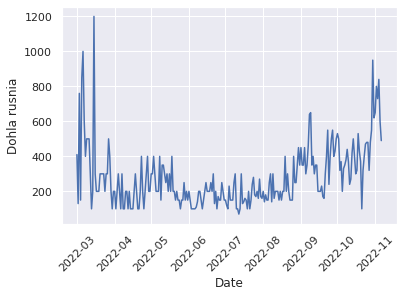

In [47]:
plt.ylabel('Dohla rusnia')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data.index, data['Personnel'])

Here we split data into train and test datasets to build a model, fit it and test it on the data we already have.

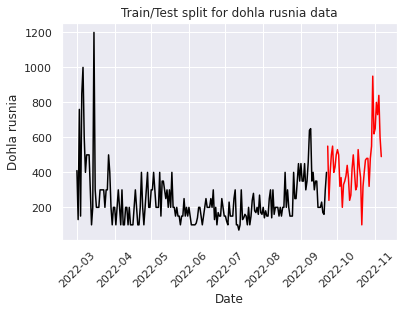

In [48]:
train = data[data.index <= pd.to_datetime(TRAIN_TEST_SPLIT_DATE, format='%d/%m/%Y')]
test = data[data.index > pd.to_datetime(TRAIN_TEST_SPLIT_DATE, format='%d/%m/%Y')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Dohla rusnia')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for dohla rusnia data")
plt.show()

### ARMA model

First I decided to go with the basic ARMA model just to get a feeling of what's going on here and how this thing behaves.

"In the statistical analysis of time series, autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression (AR) and the second for the moving average (MA). The general ARMA model was described in the 1951 thesis of Peter Whittle, Hypothesis testing in time series analysis, and it was popularized in the 1970 book by George E. P. Box and Gwilym Jenkins." - Wikipedia.

What I have understood - it's the basic model that might get the work done with little to no effort. So I tried: 

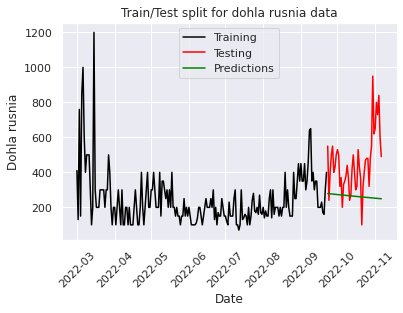

In [49]:
y = train['Personnel']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

arma_pred = ARMAmodel.get_forecast(len(test.index))
arma_pred_df = arma_pred.conf_int(alpha = 0.05) 
arma_pred_df["Predictions"] = ARMAmodel.predict(start = arma_pred_df.index[0], end = arma_pred_df.index[-1])
arma_pred_df.index = test.index
arma_pred_out = arma_pred_df["Predictions"]

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Dohla rusnia')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for dohla rusnia data")
plt.plot(arma_pred_out, color='green', label = 'Predictions')
plt.legend()

In [50]:
arma_rmse = np.sqrt(mean_squared_error(test["Personnel"].values, arma_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)

RMSE:  253.57051074180958


As you can see from the plot, ARMA model with order parameters (1,0,1) draws a line that kinda makes sense, but I wanted the curve to repeat the past pattern so I went for the ARIMA model (later on I tried the best found parameters from ARIMA for ARMA and it performed quite well).

Why the parameters 1,0,1? "The AutoRegressive Moving Average ARMA(p,q) combines both AR(p) and MA(q) processes, considering the lagged or past values and the error terms of the time series. It is the most efficient linear model of stationary time series" - from a [Medium](https://towardsdatascience.com/find-the-order-of-arima-models-b4d99d474e7a) post I used while working on this. I will list it additionally in the references.

I know, it became even more confusing. What are those parameters? - you will ask. 

"The parameters of the ARIMA model are defined as follows:
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average." - that's from the fabulous blog ["MachineLearningMastery"](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

So, as we don't need the *d* parameter for the ARMA model we left it as 0.

The RMSE is also quite big - 254.4, but hey, you have the code now to play around with all these things.

### ARIMA model

The next step was to play around with ARIMA model. I will cut to the chase here: I have played around with it manually for few hours trying to get it to work, then trying to find the best parameters of the model and later to make it a bit universal and automatic. So here is the final result.

The function *evaluate_arima_model* gets the data, makes a train/test split, builds a model based on the order supplied by the funtion params, fits it, runs a prediction on the test data and calculates an error.

In [51]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(d, arima_order):
  train = d[d.index <= pd.to_datetime(TRAIN_TEST_SPLIT_DATE, format='%d/%m/%Y')]
  test = d[d.index > pd.to_datetime(TRAIN_TEST_SPLIT_DATE, format='%d/%m/%Y')]
  y = train.iloc[0]

  ARIMAmodel = ARIMA(y, order = arima_order)
  ARIMAmodel = ARIMAmodel.fit()

  arima_pred = ARIMAmodel.get_forecast(len(test.index))
  arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
  arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
  arima_pred_df.index = test.index
  arima_pred_out = arima_pred_df["Predictions"]
	# calculate out of sample error
  error = np.sqrt(mean_squared_error(test.iloc[0].values, arima_pred_df["Predictions"]))
  return error

The function *evaluate_model* takes the dataset, a set of *p,d,q* values and brute-forces the model by trying all the combinations you give it.

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
  return best_cfg

Before setting up the ranges for *p, d, q* values I found that you can run an autocorrelation plot on your data so it will give you a better starting point for the lag param (p). Basically, the plot says that the values above dashed line are statistically significant lags. In this case I would say that 20 is a good starting point, but I decided to go conservative and selected 10 as my minimum lag value.

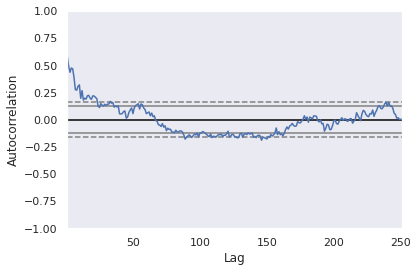

In [53]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)
plt.show()

In [54]:
# evaluate parameters
p_values = range(10,30)
d_values = range(0, 2) # the range here was found manually after few hours of plotting different values 
q_values = range(1, 20)

best_order = evaluate_models(data, p_values, d_values, q_values) # takes a lot of time depending on the amount of combinations you want to try there.
# best_order = (19, 1, 19)

The best order found was *(19, 1, 19)* so I used it to fit the model on the training data again and check how the plot looks like

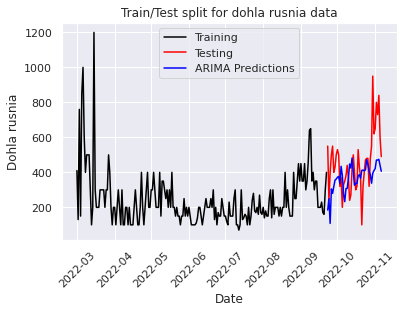

In [55]:
ARIMAmodel = ARIMA(y, order = best_order)
ARIMAmodel = ARIMAmodel.fit()

arima_pred = ARIMAmodel.get_forecast(len(test.index))
arima_pred_df = arima_pred.conf_int(alpha = 0.05) 
arima_pred_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_df.index[0], end = arima_pred_df.index[-1])
arima_pred_df.index = test.index
arima_pred_out = arima_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Dohla rusnia')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for dohla rusnia data")
plt.plot(arima_pred_out, color='blue', label = 'ARIMA Predictions')
plt.legend()

Error values looks much better here. And the predicted values more or less keep up with the real ones.

In [56]:
arima_rmse = np.sqrt(mean_squared_error(test["Personnel"].values, arima_pred_df["Predictions"]))
print("RMSE: ", arima_rmse)

RMSE:  183.07026579998552


Here, I'm also leaving the code for SARIMA or Seasonal ARIMA model. But I haven't got any seasonality in my data (well, honestly, I just couldn't understand how to use the order params for seasonality). Anyway, below you have the code and you can test it with your data.

In [57]:
# SARIMAXmodel = SARIMAX(y, order = (5,3,3), seasonal_order = (2,2,2,6))
# SARIMAXmodel = SARIMAXmodel.fit()

# sarima_pred = SARIMAXmodel.get_forecast(len(test.index))
# sarima_pred_df = sarima_pred.conf_int(alpha = 0.05) 
# sarima_pred_df["Predictions"] = SARIMAXmodel.predict(start = sarima_pred_df.index[0], end = sarima_pred_df.index[-1])
# sarima_pred_df.index = test.index
# sarima_pred_out = sarima_pred_df["Predictions"] 

# plt.plot(train, color = "black", label = 'Training')
# plt.plot(test, color = "red", label = 'Testing')
# plt.ylabel('Dohla rusnia')
# plt.xlabel('Date')
# plt.xticks(rotation=45)
# plt.title("Train/Test split for dohla rusnia data")
# plt.plot(arma_pred_out, color='green', label = 'ARMA Predictions')
# plt.plot(arima_pred_out, color='orange', label = 'ARIMA Predictions')
# plt.plot(sarima_pred_out, color='Blue', label = 'SARIMA Predictions')
# plt.legend()

In [58]:
# sarima_rmse = np.sqrt(mean_squared_error(test["Personnel"].values, sarima_pred_df["Predictions"]))
# print("RMSE: ", sarima_rmse)

Once I have found the parameters that work best for the given dataset I decided to make the predictions for the next 45 days using all the data. Below is the code for that.

In [59]:
predict = pd.DataFrame(index=pd.date_range(SDATE,EDATE-timedelta(days=1),freq='d'))
# predict['personnel'] = 0

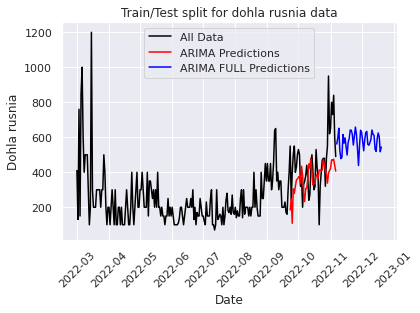

In [60]:
y_full = data['Personnel']
# y_full = train['Personnel']
ARIMAmodel = ARIMA(y_full, order = best_order)
ARIMAmodel = ARIMAmodel.fit()

arima_pred_full = ARIMAmodel.get_forecast(len(predict.index))
arima_pred_full_df = arima_pred_full.conf_int(alpha = 0.05) 
arima_pred_full_df["Predictions"] = ARIMAmodel.predict(start = arima_pred_full_df.index[0], end = arima_pred_full_df.index[-1])
arima_pred_full_df.index = predict.index
arima_pred_full_out = arima_pred_full_df["Predictions"] 

# plt.plot(train, color = "black", label = 'Training')
# plt.plot(test, color = "red", label = 'Testing')
# plt.plot(y_full, color = "black", label = 'All Data')
plt.plot(data['Personnel'], color = "black", label = 'All Data')
plt.ylabel('Dohla rusnia')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for dohla rusnia data")
plt.plot(arima_pred_out, color='red', label = 'ARIMA Predictions')
plt.plot(arima_pred_full_out, color='blue', label = 'ARIMA FULL Predictions')
plt.legend()

And a quick loop to find out the day of 100K

In [61]:
TOTAL = LAST_SUM
for index, value in arima_pred_full_out.items():
    TOTAL += int(value)
    if TOTAL >= 100000:
      print(f"100K day is : {index:%Y-%m-%d}")
      break

100K day is : 2022-12-18


That's it, 4 days of data collection, learning, investigation and parameter tuning and here you have an article with basics on how to perform time series analysis for the dummies from a dummy. I think, this is a good starting point and definitely there is a lot that can be improved here. As I lack knowledge in this domain I just don't know what that can be :D

Also, I will be running this model on my machine every day just to see how it behaves with time passing by and new data points. Because what I have noticed is that the model depends a lot on the last data point so it will be interesting to see how it changes with the time. Another good idea might be to perform hyperparameter tuning every once in a while to see if I can get better results.

I hope yu learned something while reading this! See you in the next one :)

In [62]:
# y_full = data['Personnel']
# # y_full = train['Personnel']
# SARIMAXmodel = SARIMAX(y_full, order = (5,0,3), seasonal_order = (2,2,2,6))
# SARIMAXmodel = SARIMAXmodel.fit()

# sarima_pred_full = SARIMAXmodel.get_forecast(len(predict.index))
# sarima_pred_full_df = sarima_pred_full.conf_int(alpha = 0.05) 
# sarima_pred_full_df["Predictions"] = SARIMAXmodel.predict(start = sarima_pred_full_df.index[0], end = sarima_pred_full_df.index[-1])
# sarima_pred_full_df.index = predict.index
# sarima_pred_full_out = sarima_pred_full_df["Predictions"]

# # plt.plot(train, color = "black", label = 'Training')
# # plt.plot(test, color = "red", label = 'Testing')
# # plt.plot(y_full, color = "black", label = 'All Data')
# plt.plot(data['Personnel'], color = "black", label = 'All Data')
# plt.ylabel('Dohla rusnia')
# plt.xlabel('Date')
# plt.xticks(rotation=45)
# plt.title("Train/Test split for dohla rusnia data")
# plt.plot(arma_pred_out, color='green', label = 'ARMA Predictions')
# plt.plot(arima_pred_out, color='orange', label = 'ARIMA Predictions')
# plt.plot(sarima_pred_out, color='Blue', label = 'SARIMA Predictions')
# plt.plot(sarima_pred_full_out, color='cyan', label = 'SARIMA FULL Predictions')
# plt.legend()

In [63]:
# LAST_SUM + int(sarima_pred_full_out.sum().round(0))